# Guia 5

Formación estelar / Datos SDSS y comparación con un semi-analítico


## Paquetes

In [55]:
from astropy.cosmology import Planck18 as cosmo
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import scienceplots
import seaborn as sns
import sys
sys.path.append('../')
from guia2.bimodal import fit_bimodal, normal, bimodal

In [31]:
plt.style.use('science')
_params = {
    'figure.figsize':(5*1.5,4*1.5),
    #'figure.figsize':(6.47,4), # golden ratio
    'figure.dpi':96,
    'font.family':'sans-serif',
    'font.size':15,
    'savefig.format':'png',
    'savefig.transparent':True,
    'xtick.direction':'in',
    'xtick.top':True,
    'ytick.direction':'in',
    'ytick.right':True,
    'errorbar.capsize':3,
    'legend.loc':'upper right',
    'legend.frameon':True,
    'legend.fontsize':10,
    #'axes.axisbelow':True,
}
plt.rcParams.update(_params)

## Constantes

In [3]:
CL = 'Cluster'
FD = 'Field'
SA = 'Semianalytic'

FILENAMES = {
    CL:'sample1_cls.dat',
    FD:'sample2_fd.dat',
    SA:'sample3_sim.dat'
}

COLUMNS = {
    CL:['cls', 'ra', 'dec', 'z',
        'Mr01', 'ur', 'mur', 'kr50',
        'C', 'stellarmass', 'sfr', 'ssfr',
        'Dn4000', 'class', 'Zc', 'sigma',
        'Mvir', 'Rvir', 'R200', 'w',
        'dist', 'Pe', 'Ps'
    ],
    FD:['ra', 'dec', 'z', 'Mr01',
        'ur', 'mur', 'kr50', 'C',
        'stellarmass', 'sfr', 'ssfr', 'Dn4000',
        'OH', 'w', 'Pe', 'Ps'
    ],
    SA:['cls', 'ig', 'type',  'clase',
        'stellarmass', 'u', 'g', 'r',
        'sfr', 'Mcoldgas', 'Mhotgas', 'Tau',
        'OH', 'bt', 'ssfr'
    ]
}

COLORS = {
    CL:'#7b3294',
    FD:'#008837',
    SA:'#ff7f00'
}

In [171]:
GRID = 50
LEVELS = 5
LWS = np.linspace(0.8,2.5,LEVELS)

## Funciones

In [95]:
def fitbimodal_quantiles(data, col_fit='ur', col_q='Mr01', nquantiles=5, p0=[0.5,1.5,0.3,0.5,2.5,0.2]):
    G = data[col_q]
    C_fit = data[col_fit]
    mask = []
    quantiles = []
    mean_x = []
    
    q = np.quantile(G, np.linspace(0.0,1.0,nquantiles+1)[1:-1])
    
    #print('data<q[0]')
    mask.append(G<q[0])
    quantiles.append(f'${G}<{q[0]:2.2f}$')
    mean_x.append(0.5*(G.min()+q[0]))
    for i in range(nquantiles-1):
        if i<nquantiles-2:
            #print(f'data>q[{i}] and data<q[{i+1}]')
            mask.append((G>q[i])&(G<q[i+1]))
            quantiles.append(f'${q[i]:2.2f}<{col_q}<{q[i+1]:2.2f}$')
            mean_x.append(0.5*(q[i]+q[i+1]))
        else:
            #print(f'data>q[{i}]')
            mask.append(G>q[i])
            quantiles.append(f'${col_q}>{q[i]:2.2f}$')
            mean_x.append(0.5*(q[i]+G.max()))

    fits = []
    for m in mask:
        fits.append(
            fit_bimodal(
                C_fit[m],
                p0=p0,
                nbins=50
            )
        )
    return mean_x, fits

## Catálogos

In [5]:
samples = {}
for n in [CL, FD, SA]:
    samples[n] = pd.read_fwf(FILENAMES[n], names=COLUMNS[n], skiprows=1)

In [6]:
# Agregar color u-r al semianalítico
COLUMNS[SA].append('ur')
COLUMNS[SA].append('gr')
samples[SA]['ur'] = samples[SA]['u']-samples[SA]['r']
samples[SA]['gr'] = samples[SA]['g']-samples[SA]['r']

In [7]:
# Quitando outliers
samples[CL].query('Rvir < 30 and C<4.5 and Dn4000<2.5 and Dn4000>0.5', inplace=True)
samples[FD].query('stellarmass > 8 and sfr > -8 and ur < 5 and kr50 < 20 and C < 5 and ur > 0 and Dn4000<2.5 and Dn4000>0.8 and Ps>0 and Pe>0', inplace=True)
samples[SA].query('Mhotgas != 99 and Mcoldgas != 99 and sfr!=99', inplace=True)

In [8]:
# Para automatizar el codigo, agrego una columna de "pesos" al semianalitico llena de 1
COLUMNS[SA].append('w')
samples[SA]['w'] = np.ones(len(samples[SA]['cls']))

## Propiedades de Clusters

In [9]:
cluster = samples[CL]

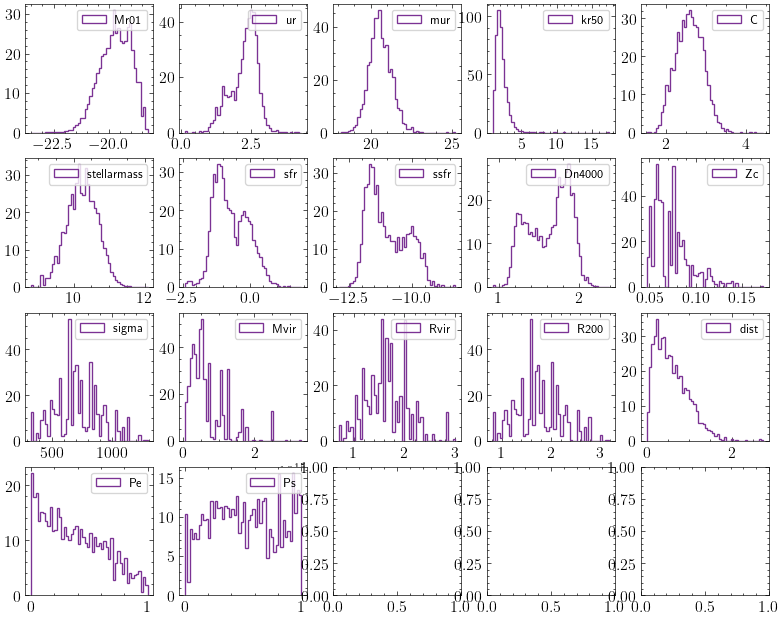

In [10]:
# Distribuciones de las columnas, pesadas por 'w'
fig, axes = plt.subplots(4,5,figsize=(10,8))
ax = axes.flatten()
i=0
for col in COLUMNS[CL]:
    if col=='cls': continue
    if col=='ra': continue
    if col=='dec': continue
    if col=='z': continue
    if col=='class': continue
    if col=='w': continue
    ax[i].hist(cluster[col], bins=50, weights=cluster['w'], histtype='step', color=COLORS[CL], label=col)
    ax[i].legend()
    i+=1

## Propiedades de Campo (?)

In [11]:
field = samples[FD]

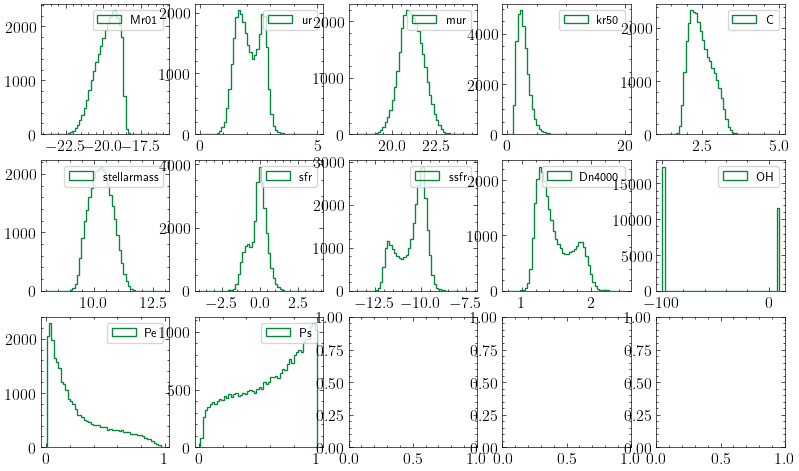

In [12]:
# Distribuciones de las columnas, pesadas por 'w'
fig, axes = plt.subplots(3,5,figsize=(10,6))
ax = axes.flatten()
i=0
for col in COLUMNS[FD]:
    if col=='ra': continue
    if col=='dec': continue
    if col=='z': continue
    if col=='w': continue
    ax[i].hist(field[col], bins=50, weights=field['w'], histtype='step', color=COLORS[FD], label=col)
    ax[i].legend()
    i+=1

## Propiedades Semianalítico

In [13]:
semia = samples[SA]

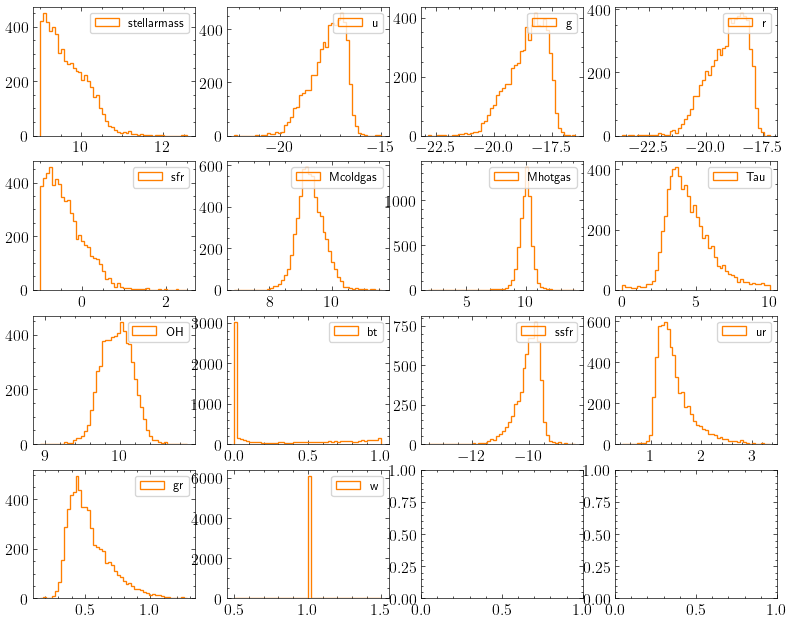

In [14]:
# Distribuciones de las columnas
fig, axes = plt.subplots(4,4,figsize=(10,8))
ax = axes.flatten()
i=0
for col in COLUMNS[SA]:
    if col=='cls': continue
    if col=='ig': continue
    if col=='type': continue
    if col=='clase': continue
    ax[i].hist(semia[col], bins=50, histtype='step', color=COLORS[SA], label=col)
    ax[i].legend()
    i+=1

## Comparación cluster-campo
Cluster y campo, semianalitico no tiene redshift

Distribución de redshift

Text(0.5, 0, 'Redshift')

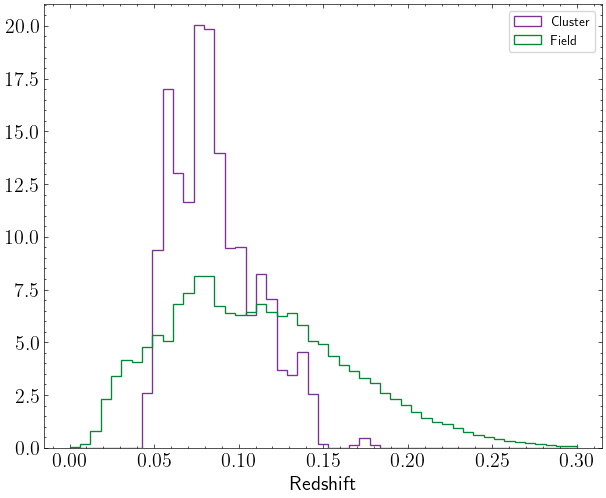

In [32]:

bins = np.linspace(0.0, 0.3, 50)

fig, ax = plt.subplots()
for n in [CL, FD]:
    ax.hist(
        samples[n]['z'],
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )
ax.legend()
ax.set_xlabel('Redshift')

Completitud

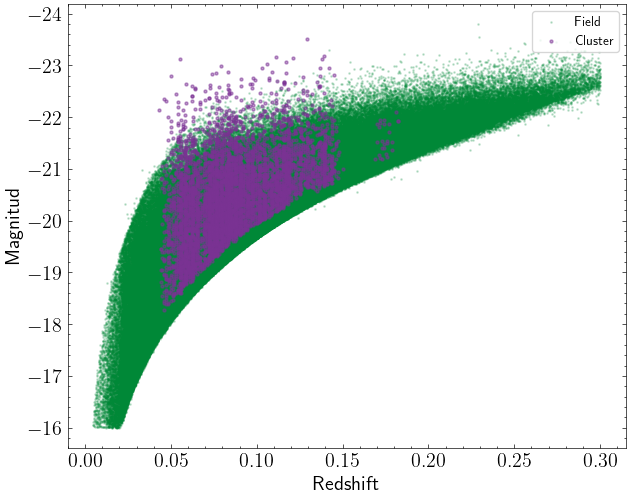

In [46]:

fig, ax = plt.subplots()

for i,n in enumerate([FD, CL]):
    ax.scatter(
        samples[n]['z'], samples[n]['Mr01'], 
        s=1 if n==FD else 5, alpha=0.2 if n==FD else 0.5, label=n, color=COLORS[n]
    )

ax.set_xlabel('Redshift')
ax.set_ylabel('Magnitud')
ax.invert_yaxis()
ax.legend()

Vemos que los catalogos de campo y cluster no son comparables, se debe realizar un corte en redshift para poder tomar muestras compatibles.

Para eso, se toman redshfits entre $0.05 \leq z \leq 0.14$, que son aproximadamente el rango donde tenemos clusters. Fuera del rango, sólo se tienen galaxias de campo. 

Además se utilizará una muestra completa por flujo, que implica pesar por $1/V_{\mathrm{max}}$ en las siguientes figuras.

In [34]:
z_cut = 'z > 0.05 and z < 0.14'

In [18]:
S = {} # Muestra que utilizaremos de aquí en adelante
for n in [CL,FD]:
    S[n] = samples[n].query(z_cut, inplace=False)
S[SA] = samples[SA]

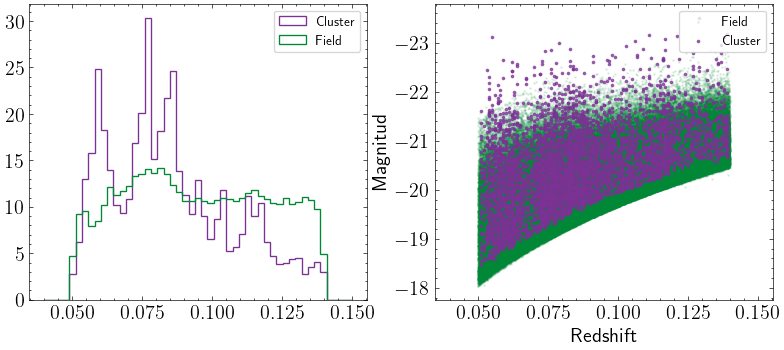

In [35]:

bins = np.linspace(0.04, 0.15, 50)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4),sharex=True)

for n in [CL, FD]:
    ax1.hist(
        S[n]['z'],
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )
ax1.legend()

for i,n in enumerate([FD, CL]):
    ax2.scatter(
        S[n]['z'], S[n]['Mr01'], 
        s=1 if n==FD else 3, alpha=0.1 if n==FD else 0.7, 
        label=n, color=COLORS[n]
    )

ax2.set_xlabel('Redshift')
ax2.set_ylabel('Magnitud')
ax2.invert_yaxis()
ax2.legend()

### Distribución de masa estelar M$_{\star}$
Son comparables los dos catálogos?

pvalue = 5.01e-17
Las muestras son diferentes


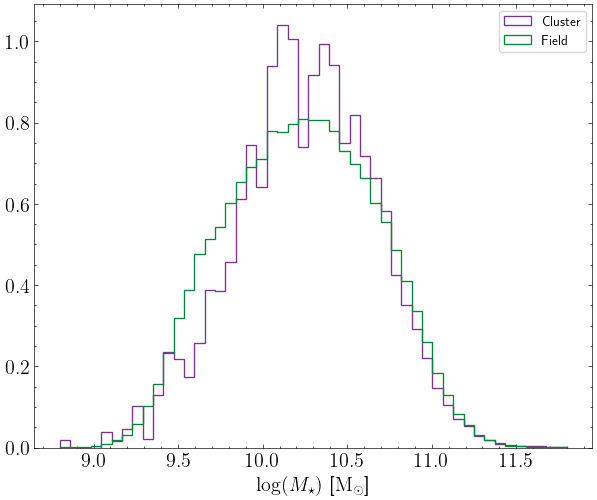

In [37]:

bins = np.linspace(8.8, 11.8, 50)
fig, ax = plt.subplots()

for n in [CL,FD]:
    ax.hist(
        S[n]['stellarmass'], 
        weights=S[n]['w'], 
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )

ax.set_xlabel('$\log(M_{\star})$ [$\mathrm{M}_{\odot}$]')
ax.legend();

# Son muestras similares?
ks_res = ks_2samp(S[CL]['stellarmass'], S[FD]['stellarmass'], method='exact')
print(f'pvalue = {ks_res.pvalue:2.2e}')
if ks_res.pvalue > 0.05:
    print('La información no es suficiente para rechazar la hip. nula')
else:
    print('Las muestras son diferentes')

El KS-test muestra que las distribuciones de masa estelar son diferentes, es decir, las masas de ambos catálogos son diferentes.

De la figura anterior se puede ver que las galaxias de campo tienen un exceso de densidad en masas entre $9.5<\log M_{\star}<10$ respecto a las de cúmulo, mientras que estas ultimas tienen masas en el rango $10<\log M_{\star}<10.5$ de manera más frecuente que las de campo. 

In [ ]:
fig, ax = plt.subplots()

for n in [CL, FD, SA]:
    ax.plot([],[], lw=1.5, c=COLORS[n], label=n)
    sns.kdeplot(
        ax = ax,
        data=S[n], 
        x='stellarmass', y='ssfr', weights='w',
        gridsize=GRID, levels=LEVELS, linewidths=LWS,
        color=COLORS[n]
    )
ax.legend()
ax.set_xlim(8.8, 11.8)

Podemos realizar ahora un analisis en bines de masa estelar...

Se separan en 5 intervalos equiespaciados de $\log M_{\star}$ entre $8.8$ y $11.8$. 

In [151]:
# Separamos en n bines de masa
n_masa = 6
b_mstar = np.linspace(8.8,11.8,n_masa+1)
b_mstar = (b_mstar[:-1] + np.diff(b_mstar)*0.5)
print('Bordes de los bines: ', b_mstar)

mstar = {}
for i in range(n_masa-1):
    massbin = f'{b_mstar[i]:2.2f}-{b_mstar[i+1]:2.2f}'
    mstar[massbin] = {}
    for n in [CL,FD]:
        mstar[massbin][n] = S[n].query(
            f'stellarmass > {b_mstar[i]} and stellarmass < {b_mstar[i+1]}', 
            inplace=False
        )

Bordes de los bines:  [ 9.05  9.55 10.05 10.55 11.05 11.55]


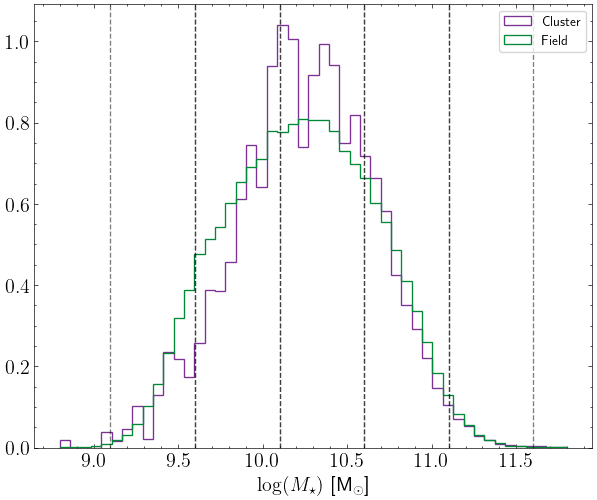

In [40]:

bins = np.linspace(8.8, 11.8, 50)
fig, ax = plt.subplots()

for n in [CL,FD]:
    ax.hist(
        S[n]['stellarmass'], 
        weights=S[n]['w'], 
        bins=bins, 
        density=True, 
        histtype='step', 
        label=n, 
        color=COLORS[n]
    )

for b in mstar.keys():
    ax.axvline(float(b.split('-')[0]), ls='--', color='k', alpha=0.5)
    ax.axvline(float(b.split('-')[1]), ls='--', color='k', alpha=0.5)

ax.set_xlabel('$\log(M_{\star})$ [M$_{\odot}$]')
ax.legend();

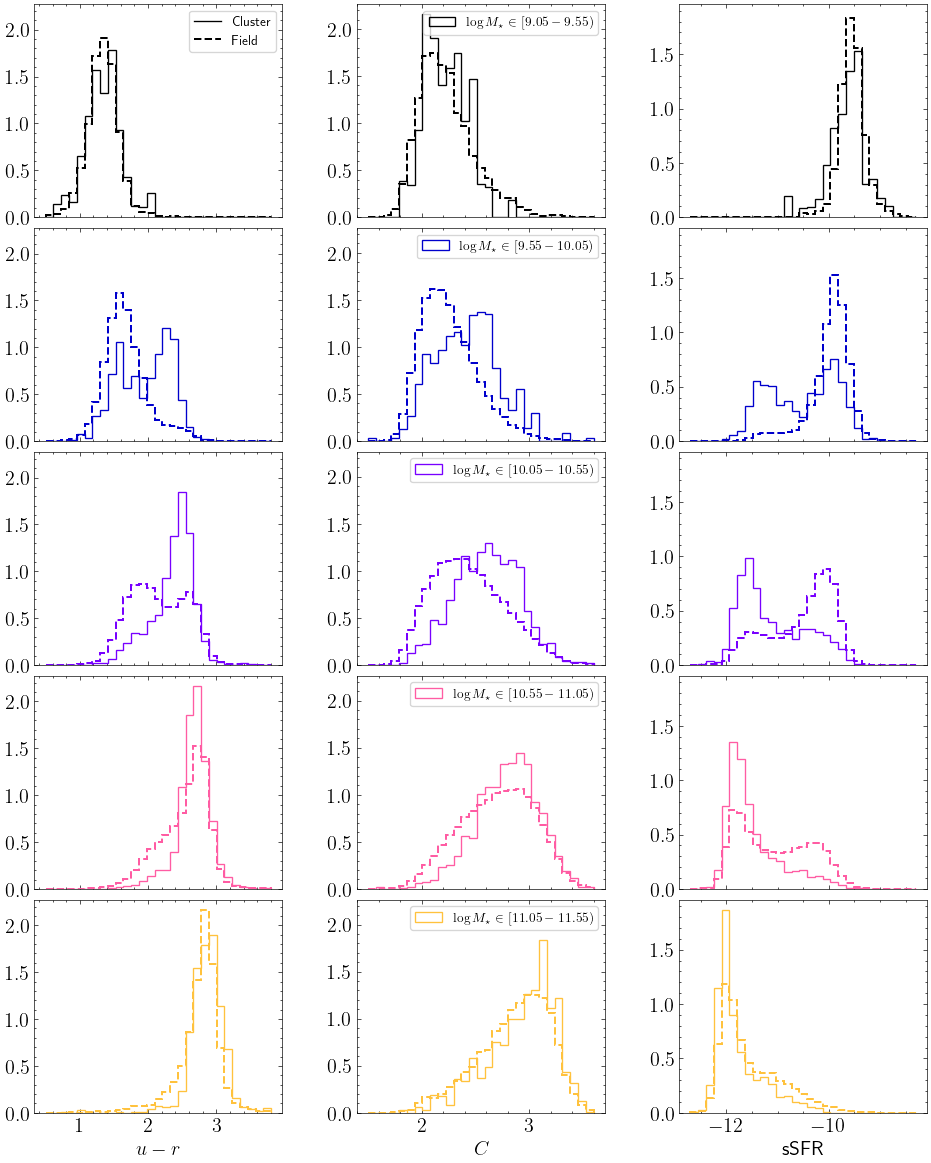

In [150]:
# Distribuciones de color de las dif masas
bins_ur = np.linspace(0.5,3.8,30)
bins_c = np.linspace(1.5,3.6,30)
bins_ssfr = np.linspace(-12.7,-8.3,30)
cmap = plt.get_cmap('gnuplot2', n_masa)
fig, axes = plt.subplots(5,3,figsize=(12,15), sharex='col', sharey='col')

axes[0,0].plot([],[],color='k',label=CL)
axes[0,0].plot([],[],ls='--',lw=1.5,color='k',label=FD)
axes[0,0].legend()
i=0
for b,S_star in mstar.items():
    axes[i,0].hist(S_star[CL]['ur'], bins=bins_ur, weights=S_star[CL]['w'], histtype='step', density=True, color=cmap(i))
    axes[i,0].hist(S_star[FD]['ur'], bins=bins_ur, weights=S_star[FD]['w'], histtype='step', density=True, color=cmap(i), linewidth=1.5, linestyle='--')
    
    axes[i,1].hist(S_star[CL]['C'], bins=bins_c, weights=S_star[CL]['w'], histtype='step', density=True, color=cmap(i), label=f'$ \\log M_\\star \\in [{b})$')
    axes[i,1].hist(S_star[FD]['C'], bins=bins_c, weights=S_star[FD]['w'], histtype='step', density=True, color=cmap(i), linewidth=1.5, linestyle='--')

    axes[i,2].hist(S_star[CL]['ssfr'], bins=bins_ssfr, weights=S_star[CL]['w'], histtype='step', density=True, color=cmap(i))
    axes[i,2].hist(S_star[FD]['ssfr'], bins=bins_ssfr, weights=S_star[FD]['w'], histtype='step', density=True, color=cmap(i), linewidth=1.5, linestyle='--')
    
    axes[i,1].legend()
    i+=1

    # Son muestras similares?
    #display(Math(fr'$\log M {{\star}} \in [{b})$'))
    #for col in ['ur', 'C']:
    #    ks_res = ks_2samp(S_star[CL][col], S_star[FD][col], method='exact')
    #    print(f'pvalue = {ks_res.pvalue:2.2e}')
    #    if ks_res.pvalue > 0.05:
    #        print(f'{col}: No es posible rechazar la hip. nula\n')
    #    else:
    #        print(f'{col}: Las muestras son diferentes\n')
    
axes[-1,0].set_xlabel('$u-r$')
axes[-1,1].set_xlabel('$C$')
axes[-1,2].set_xlabel('sSFR')

fig.subplots_adjust(wspace=0.3, hspace=0.05)


Es posible observar que para los intervalos de masa en los extremos, las distribuciones de color y concentración son similares, mientras que los tres intervalos centrales presentan las mayores diferencias. Una de ellas es la bimodalidad del color, para $\log M_{\star} \in [9.55-10.05)$ en la muestra de clusters esta bimodalidad está presente y las de campo son en su mayoría azules, para $\log M_{\star} \in [10.05-10.55)$ ahora las galaxias de cluster son en su mayoría rojas mientras que las de campo tienen una fuerte bimodalidad y para $\log M_{\star} \in [10.55-11.05)$ las componentes azules son minoritarias en ambos ambientes, con la población azul de cluster aún menor que la de campo. 

Por su parte, se puede observar de la concentración que la población de early-type ($C>2.5$) se vuelve mayoritaria con la masa para ambos catalogos. En particular para los intervalos de $\log M_{\star} \in [9.55-10.05)$ y $[10.05-10.55)$ se observa una mayor población de late-type en el campo que en los cluster. 

# ETC

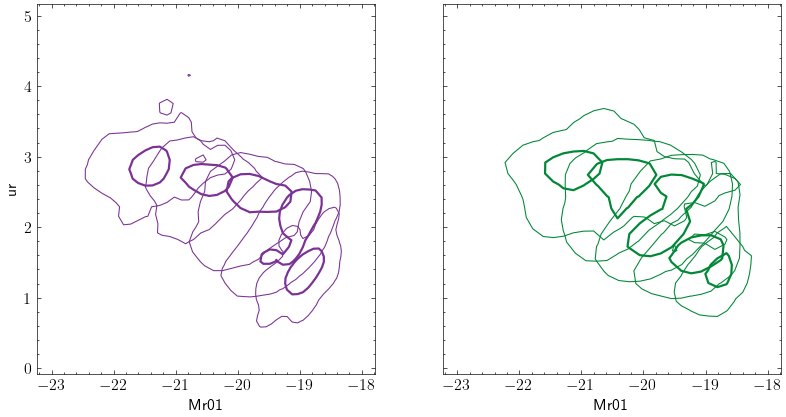

In [24]:
# Veamos algunos contornos...
# logM vs ur
GRID = 30
LEVELS = 3
LWS = np.linspace(0.8,2.5,LEVELS)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

for b, S_star in mstar.items():
    sns.kdeplot(
        ax=ax1, 
        data=S_star[CL], 
        x='Mr01', 
        y='ur', 
        weights='w', 
        levels=LEVELS, 
        gridsize=GRID, 
        linewidths=LWS, 
        color=COLORS[CL]
    )
    sns.kdeplot(
        ax=ax2, 
        data=S_star[FD], 
        x='Mr01', 
        y='ur', 
        weights='w', 
        levels=LEVELS, 
        gridsize=GRID, 
        linewidths=LWS, 
        color=COLORS[FD]
    )

[-21.8405, -20.646, -20.2805, -19.852, -18.817999999999998]


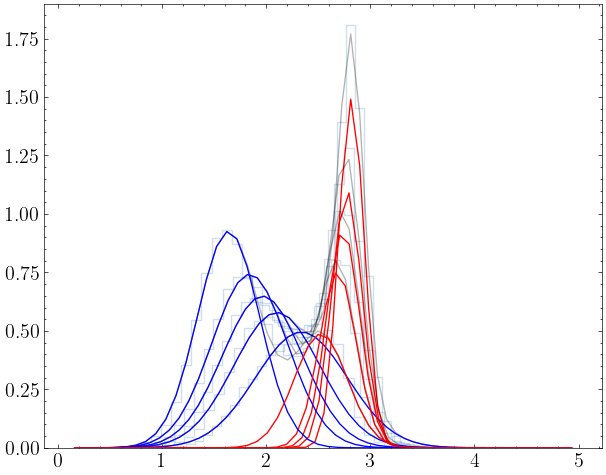

In [93]:
m, f = fitbimodal_quantiles(S[FD], col_fit='ur', col_q='Mr01', nquantiles=5)
for fi in f:
    plt.stairs(fi['y'], fi['xedges'], color='C0', alpha=0.2)
    plt.plot(fi['x'], fi['yfit'], c='k', alpha=0.3)
    plt.plot(fi['x'], fi['popt'][0]*normal(fi['x'], fi['popt'][1], fi['popt'][2]), c='b')
    plt.plot(fi['x'], fi['popt'][3]*normal(fi['x'], fi['popt'][4], fi['popt'][5]), c='r')

print(m)

<Figure size 720x576 with 0 Axes>

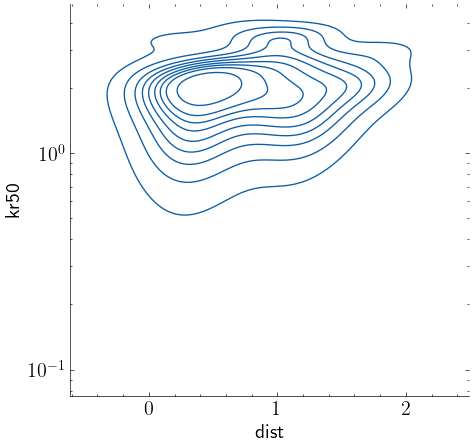

<Figure size 720x576 with 0 Axes>

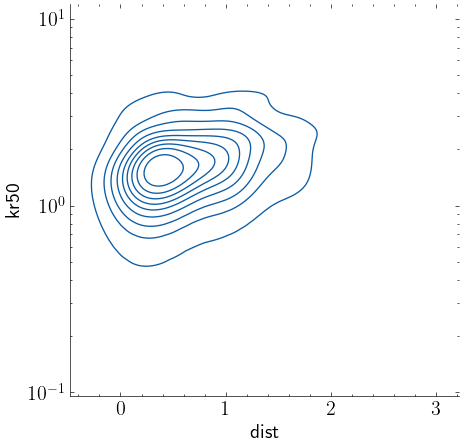

<Figure size 720x576 with 0 Axes>

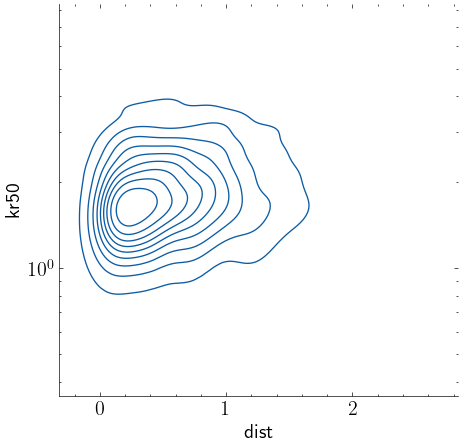

<Figure size 720x576 with 0 Axes>

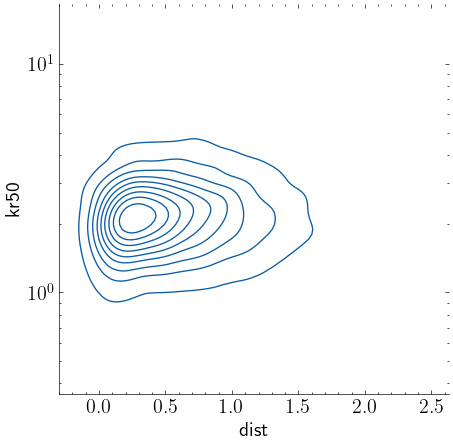

<Figure size 720x576 with 0 Axes>

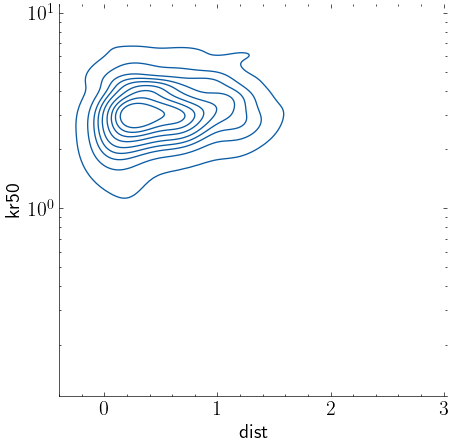

In [89]:
for b, S_star in mstar.items():
    plt.figure()
    sns.displot(data=S_star[CL], x='dist', y='kr50', weights='w', kind='kde')
    plt.semilogy()